# Note that Task 3 also executes same process as Task 2, and then performs adjustment on the aligned image

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

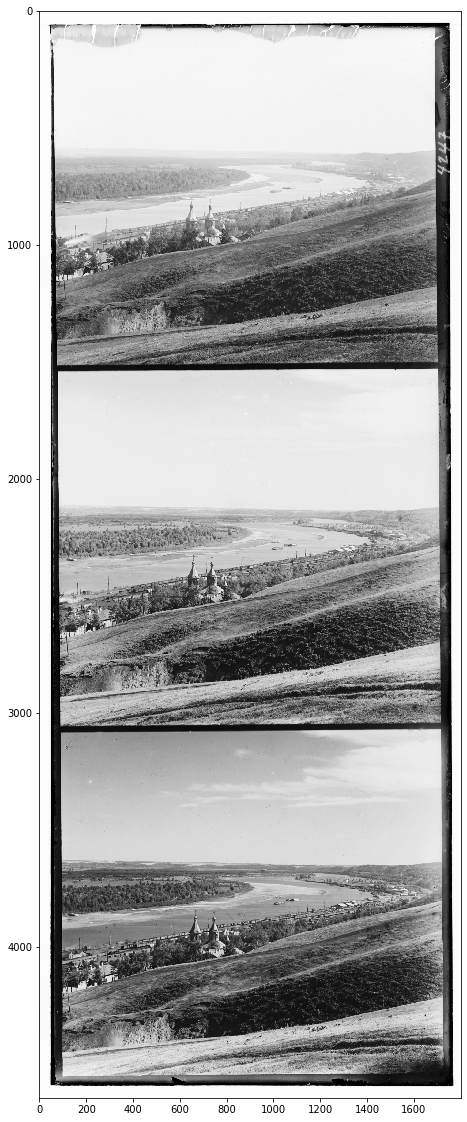

In [151]:
# Replace this string to the file that you want to align (must be in same directory as notebook)
file_str = "00549u"
file_type = ".jpg"
# Read in an image
img = cv2.imread(file_str + file_type)

# Make figures bigger so its easier to see images
plt.rcParams["figure.figsize"] = (30,20)

# Convert to grayscale and display
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img,cmap='gray')

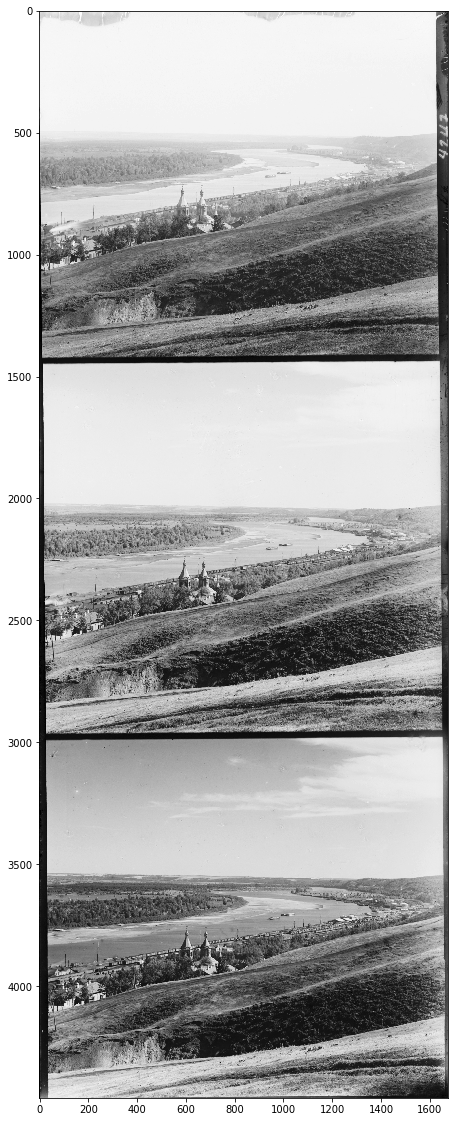

In [152]:
# Rudimentary cropping, performed by cropped a % of the width and height of the image
amount_w = 0.035
amount_h = 0.02
crop_width = round(img.shape[1] * amount_w)
crop_height = round(img.shape[0] * amount_h)
cropped_img = img[crop_height:-crop_height,crop_width:-crop_width]

# Trim off bottom rows until height is evenly divisible by 3
# so that it can be separated into B,G,R channels (just makes this cleaner)
while cropped_img.shape[0] % 3 != 0:
    cropped_img = cropped_img[:-1,:]
    
# Display cropped image
plt.imshow(cropped_img,cmap='gray')

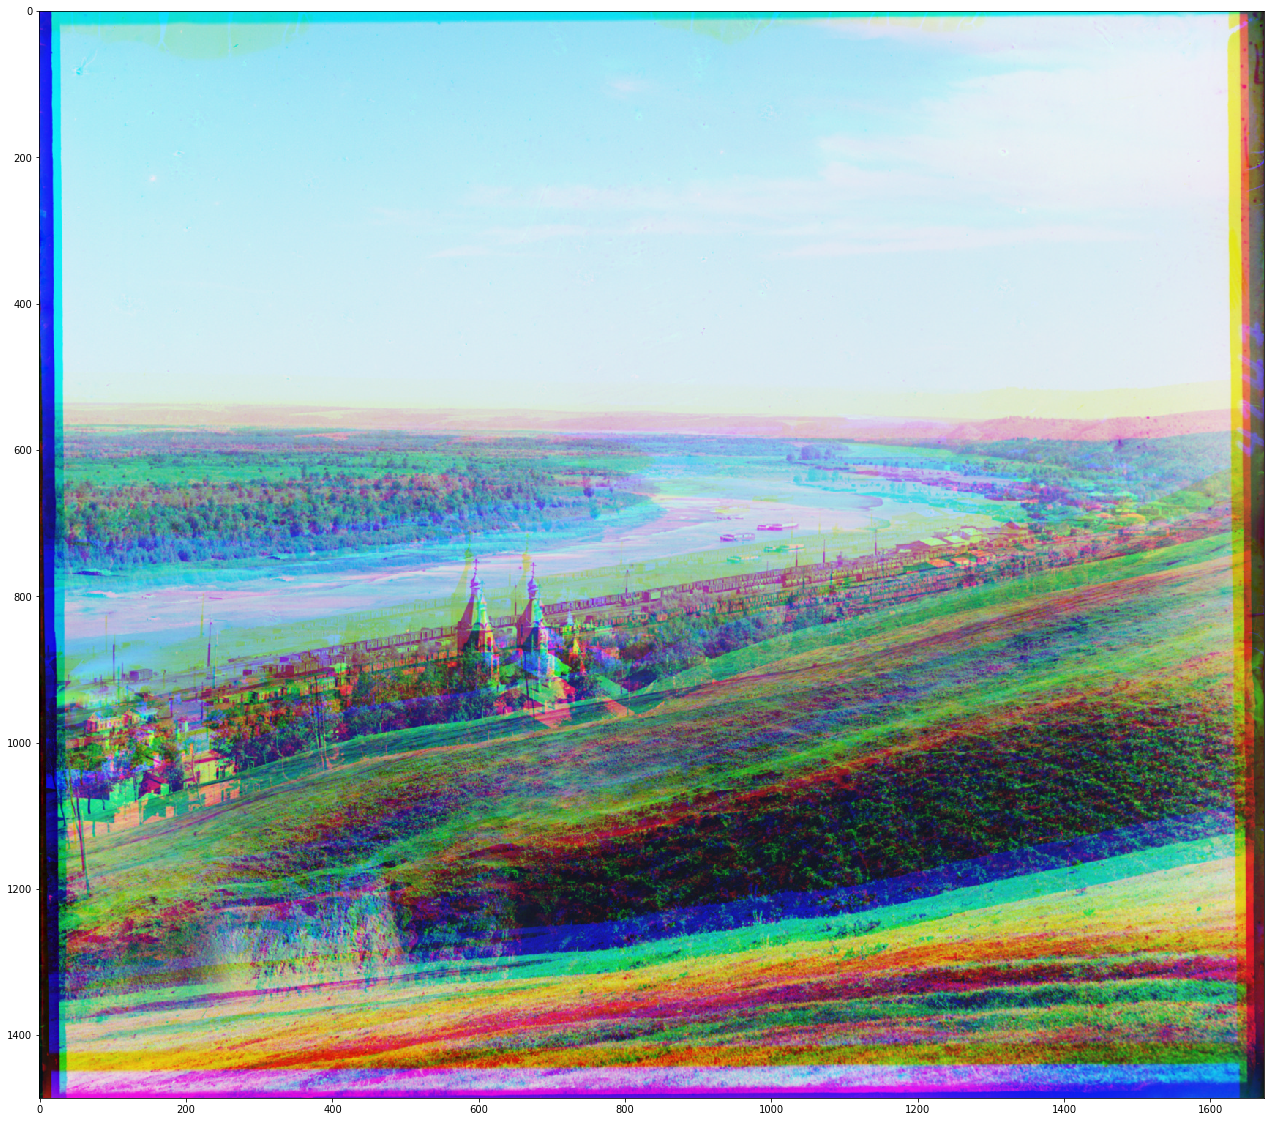

In [153]:
# Now that white border has been (roughly) cropped, simply divide image height-wise
#into 3 sections to form the B, G, and R channels
img_height = cropped_img.shape[0]

l = round(img_height/3)
b = cropped_img[0:l,:]
g = cropped_img[l:2*l,:]
r = cropped_img[2*l:,:]

# Stack into coloured image (BGR for OpenCV)
img_bgr = np.dstack((b,g,r))

# Convert to RGB so matplotlib can display
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

Level 0/5
Aligning green channel...
Aligning red channel...
Level 1/5
Aligning green channel...
Aligning red channel...
Level 2/5
Aligning green channel...
Aligning red channel...
Level 3/5
Aligning green channel...
Aligning red channel...
Level 4/5
Aligning green channel...
Aligning red channel...
Level 5/5
Aligning green channel...
Aligning red channel...
Found offsets: 
Green: i = -38, j = -10
Red: i = -68, j = -17


True

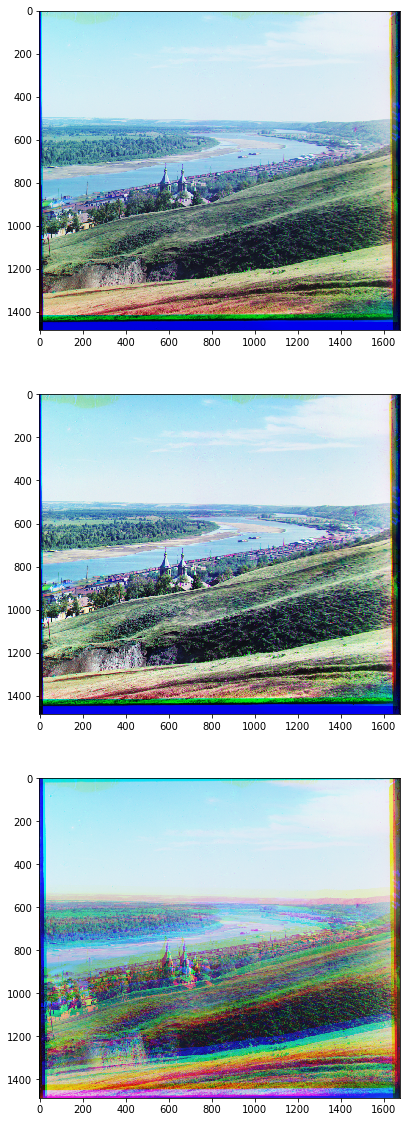

In [154]:
# Returns a list of images corresponding to image pyramid
def image_pyramid(base_img, num_levels):
    pyramid = []
    pyramid.append(base_img)
    # Apply cv2.resize() to reduce image by 50% in both directions
    for i in range(num_levels-1):
        width = int(pyramid[i].shape[1] * 0.5)
        height = int(pyramid[i].shape[0] * 0.5)
        scaled_img = cv2.resize(pyramid[i],(width,height),cv2.INTER_LINEAR)
        pyramid.append(scaled_img)
    return pyramid



# Aligns img_b to img_a by holding img_a still and sliding img_b +/- num_offsets over img_a
# and calculating a score for how well it is aligned
# returns aligned image (same size as img_a and img_b), the offset for the aligned image
# and the calculated score
def align_channel(img_a, img_b, num_offsets, start_i, start_j):
    best_i = 0
    best_j = 0
    best_img_b = []

    # start with zero score so that first calculated score is guaranteed to be more
    best_score = 0
    
    # Loop through offsets from (start_i/j - num_offsets) to (start_i/j + num_offsets)
    for i in range(start_i-num_offsets, start_i+num_offsets + 1):
        for j in range(start_j-num_offsets, start_j+num_offsets + 1):
            # Roll img_b by current offsets that are being tested
            img_b_roll = np.roll(img_b, [i, j], axis=(0,1))
            
            # Bit mask new_img_b, set all values outside of new image boundaries to 0
            mask = np.zeros(img_b.shape)
            
            # Wherever np.roll() "rolled over" intensity values, set these locations to 1 in the mask
            if i < 0:
                mask[(mask.shape[0]+i):,:] = 1
            elif i > 0:
                mask[:i,:] = 1
            if j < 0:
                mask[:,(mask.shape[1]+j):] = 1
            elif j > 0:
                mask[:,:j] = 1
                
            # now need to invert the mask and multiply with img_b_roll to clear the intensity values
            # that "rolled over", the result 0 columns and rows will be used to trim the image to only
            # the overlapping area
            mask = 1 - mask

            img_b_masked = img_b_roll * mask

            # Trim both channels so that all we have left
            # is overlapping area to perform metric on
            new_img_a = img_a[~np.all(img_b_masked == 0, axis=1),:]
            
            new_img_a = new_img_a[:, ~np.all(img_b_masked == 0, axis=0)]
            
            new_img_b = img_b_masked[~np.all(img_b_masked == 0, axis=1),:]
            
            new_img_b = new_img_b[:, ~np.all(img_b_masked == 0, axis=0)]
            
            # Calculate score for current offset, if it's higher (ie better) than current score
            # then update best offset and image
            nccoeff = cv2.matchTemplate(new_img_b.astype(np.uint8), new_img_a.astype(np.uint8), cv2.TM_CCOEFF_NORMED)
            if nccoeff > best_score:
                best_score = nccoeff
                best_i = i
                best_j = j
                best_img_b = img_b_masked
    return (best_img_b, best_i, best_j, best_score)


# Number of offsets to search
num_offsets = 10

# Minimum width for a level in the pyramid
min_width = 50

img_width = img_bgr.shape[1]

# Number of levels in pyramid is num_levels + 1 (since we have base image too)
num_levels = math.ceil(np.log2(img_width/min_width))

pyramid = image_pyramid(img_bgr, num_levels)
pyramid.reverse()

start_i_g = 0
start_j_g = 0
start_i_r = 0
start_j_r = 0

# Iterate through pyramid from lowest to highest resolution
for i in range(len(pyramid)):
    print("Level " + str(i) + "/" + str(num_levels-1))
    b = pyramid[i][:,:,0]
    g = pyramid[i][:,:,1]
    r = pyramid[i][:,:,2]
    # Align green channel to blue
    print("Aligning green channel...")
    img_g, next_i_g, next_j_g, score_g = align_channel(b,g,num_offsets,start_i_g*2,start_j_g*2)
    # Align red channel to blue
    print("Aligning red channel...")
    img_r, next_i_r, next_j_r, score_r = align_channel(b,r,num_offsets,start_i_r*2,start_j_r*2)
    start_i_g = next_i_g
    start_j_g = next_j_g
    start_i_r = next_i_r
    start_j_r = next_j_r
    
i_g = start_i_g
j_g = start_j_g
i_r = start_i_r
j_r = start_j_r

g = img_g.astype(np.uint8)
r = img_r.astype(np.uint8)

# Print optimal offsets
print("Found offsets: ")
print("Green: i = " + str(i_g) + ", j = " + str(j_g))
print("Red: i = " + str(i_r) + ", j = " + str(j_r))

final_img = np.dstack((b,g,r))

# Create a Contrast-Limited Adaptive Histogram Equalization object
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))

# Pass each channel individually to this object and apply CLAHE to it
b = clahe.apply(b)
g = clahe.apply(g)
r = clahe.apply(r)

final_img_eq = np.dstack((b,g,r))

final_img_rgb = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
final_img_eq_rgb = cv2.cvtColor(final_img_eq, cv2.COLOR_BGR2RGB)

# Plot unadjusted aligned image
plt.subplot(3,1,1)
plt.imshow(final_img_rgb)
# Plot CLAHE adjusted aligned image
plt.subplot(3,1,2)
plt.imshow(final_img_eq_rgb)
# Plot unadjusted original misaligned image
plt.subplot(3,1,3)
plt.imshow(img_rgb)

# Write unadjusted aligned image to file
cv2.imwrite(file_str + "_task3.png", final_img)
# Write CLAHE adjusted aligned image to file
cv2.imwrite(file_str + "_eq_task3.png", final_img_eq)
# Write unadjusted misaligned image to file
cv2.imwrite(file_str + "_orig_task3.png", img_bgr)